### Imports

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.markers import MarkerStyle
plt.ioff()
from NTM.utility import create_directory
import ast
import os

class Grid(object):
    def __init__(self, ID, inlet, outlet, height, width, buffer='B', mixer_cycles=13):
        # @ID -> string 
        # @inlet -> str([x,y])
        # @outlet -> str([x,y])
        # @size -> [Height, Width] -> [int, int]
        # @buffer -> string
        self.ID = ID
        self.INLET = inlet
        self.OUTLET = outlet
        self.HEIGHT, self.WIDTH = height, width
        self.BUFFER = buffer
        self.MIXER_CYCLES = mixer_cycles
        
        self.G = self._init_graph()
        self.timecycle = 1
        self._plot_grid(self.G)
        return
        
    def load(self, fluid, NS):
        load_route, wash_route, alternate_wash_route = self._find_route(self.G, NS)
        
        # Flow the fluid along load_route
        self._flow(self.G, fluid, load_route)
        
        # Mark NS as 'used'
        self._mark_nodes(self.G, used=NS, unused=[])
        
        # Flow the buffer along wash_route
        self._flow(self.G, self.BUFFER, wash_route)
        
        if alternate_wash_route != []:
            # Flow the buffer along alternate_wash_route
            self._flow(self.G, self.BUFFER, alternate_wash_route)
        
        ### snapshot ###
        self._plot_grid(self.G)
        return
        
    def mix(self, mixer_list):
        for cycle in range(self.MIXER_CYCLES):
            # Open/Close the required valves for mixer module
            valves_open, valves_close = [], []
            if (cycle == 0):
                for mix_label, mixer_route in mixer_list:
                    valves_open_i, valves_close_i = self._find_valves(self.G, mixer_route, cycle=True)
                    
                    self._mark_valves(self.G, valves_open_i, valves_close_i)
            elif (cycle == self.MIXER_CYCLES-1):
                for mix_label, mixer_route in mixer_list:
                    valves_open_i, valves_close_i = self._find_valves(self.G, mixer_route, cycle=True)
                    
                    self._mark_valves(self.G, [], valves_open_i+valves_close_i)
                    
                    for j in range(len(mixer_route)):
                        self.G.nodes[mixer_route[j]]['contains'] = mix_label
            else:
                i = cycle
                for mix_label, mixer_route in mixer_list:
                    valves_open_i = [ [mixer_route[(i-2)%len(mixer_route)], mixer_route[(i-1)%len(mixer_route)]] ]
                    valves_close_i = [ [mixer_route[(i-1)%len(mixer_route)], mixer_route[(i)%len(mixer_route)]] ]
                    
                    self._mark_valves(self.G, valves_open_i, valves_close_i)
                    
                    r = [self.G.nodes[mixer_route[j]]['contains'] for j in range(len(mixer_route))]
                    for j in range(len(mixer_route)):
                        self.G.nodes[mixer_route[j]]['contains'] = r[(j-1)%len(mixer_route)]
                
            concat_mixer_list = []
            for _, item in mixer_list:
                concat_mixer_list += item
            ### snapshot ###
            self._plot_grid(self.G, concat_mixer_list)
            
        ### snapshot ###
        self._plot_grid(self.G)
        return
        
    def wash(self, NS):
        wash_route, _x, _y = self._find_route(self.G, NS)
        
        # Flow the buffer along wash_route
        self._flow(self.G, self.BUFFER, wash_route)
        
        # Mark wash_route as 'un-used'
        self._mark_nodes(self.G, used=[], unused=NS)
        
        ### snapshot ###
        self._plot_grid(self.G)
        return
    
    
    ############# Helper Functions ##############
    # @node -> str([x,y])
    # @valve represents an edge -> [str(x1,y1), str(x2,y2)]
    # @NS means node sequence i.e. a sequential list of adjacent nodes -> [node]
    # @route is a sequential list of adjacent from INLET to OUTLET -> [node]
    def _init_graph(self):
        # Draw the PMD Grid Graph
        # Node Attribute: 'used' = 0, by default
        # Edge Attribute: 'valve' = 0, by default  [0]=> close, [1]=> open
        height, width = self.HEIGHT, self.WIDTH
        buffer = self.BUFFER
        
        D = nx.Graph()
        pos = {}
        for y in range(height):
            for x in range(width):
                coord = [x, y]
                pos[str(coord)] = coord
                D.add_node(str(coord), used=0, contains=buffer)
                if (x>0):
                    D.add_edge(str([x-1, y]), str(coord), valve=0)
                if (y>0):
                    D.add_edge(str([x, y-1]), str(coord), valve=0)
        return D
    
    def _flow(self, G, fluid, route):  
        # Mark route as 'used'
        self._mark_nodes(self.G, used=route, unused=[])
        
        # Opening/Closing required valves along route
        valves_open, valves_close = self._find_valves(G, route)
        self._mark_valves(G, valves_open, valves_close)
        ### snapshot ###
        self._plot_grid(self.G, route)
        
        # Push fluid for 't' cycles, where 't' = length of route
        for _ in range(len(route)):
            for i in range(len(route)-1, 0, -1):
                G.nodes[route[i]]['contains'] = G.nodes[route[i-1]]['contains']
            G.nodes[route[0]]['contains'] = fluid
            ### snapshot ###
            self._plot_grid(self.G, route)
        
        # Mark route as 'un-used'
        self._mark_nodes(self.G, used=[], unused=route)
        return
        
    def _find_route(self, G, load_NS):
        # finds a route from INLET to first node in NS through NS to last node of NS to OUTLET for loading
        # finds a route same as prev. route except the load_NS for washing
        inlet, outlet = self.INLET, self.OUTLET
        Gprime = deepcopy(G)
        
        self._mark_nodes(Gprime, used=[], unused=load_NS)
        path1 = nx.dijkstra_path(Gprime, inlet, load_NS[0], weight = lambda u, v, d: True if not Gprime.nodes[u]['used'] and not Gprime.nodes[v]['used'] else None)
        
        self._mark_nodes(Gprime, used=path1+load_NS, unused=[])
        self._mark_nodes(Gprime, used=[], unused=[load_NS[-1]])
        try:
            path2 = nx.dijkstra_path(Gprime, load_NS[-1], outlet, weight = lambda u, v, d: True if not Gprime.nodes[u]['used'] and not Gprime.nodes[v]['used'] else None)
        except nx.NetworkXNoPath:
            path2 = nx.dijkstra_path(Gprime, load_NS[-1], outlet, weight = lambda u, v, d: True if not Gprime.nodes[u]['used'] and not Gprime.nodes[v]['used'] else None)
            print ('load route not found to load_NS={}'.format(load_NS))
            print("used nodes are:")
            for node in Gprime.nodes(data=True):
                if node[1]['used'] == 1:
                    print (node)
            print ('end exception1')
        
        self._mark_nodes(Gprime, used=path1+load_NS+path2, unused=[])
        self._mark_nodes(Gprime, used=[], unused=[path1[-2], path2[1]])
        try:
            wash_NS = nx.dijkstra_path(Gprime, path1[-2], path2[1], weight = lambda u, v, d: True if not Gprime.nodes[u]['used'] and not Gprime.nodes[v]['used'] else None)
        except nx.NetworkXNoPath:
            print ('wash route not found to load_NS={}'.format(load_NS))
            print ("load_route found is:", path1+load_NS+path2)
            print("used nodes are:")
            for node in Gprime.nodes(data=True):
                if node[1]['used'] == 1:
                    print (node)
            print ("end exception2. Now, going for second option...")
            self._mark_nodes(Gprime, used=[], unused=[path1[-2]]+path2[1:])
            wash1 = nx.dijkstra_path(Gprime, path1[-2], outlet, weight = lambda u, v, d: True if not Gprime.nodes[u]['used'] and not Gprime.nodes[v]['used'] else None)
            
            self._mark_nodes(Gprime, used=path1+load_NS+path2, unused=[])
            self._mark_nodes(Gprime, used=[], unused=[path2[1]]+path1[:-1])
            wash2 = nx.dijkstra_path(Gprime, inlet, path2[1], weight = lambda u, v, d: True if not Gprime.nodes[u]['used'] and not Gprime.nodes[v]['used'] else None)
        
            return path1[:-1] + load_NS + path2[1:], path1[:-2]+wash1, wash2+path2[2:]
        return path1[:-1] + load_NS + path2[1:], path1[:-2] + wash_NS + path2[2:], []
    
    def _find_valves(self, G, path, cycle=False):
        # this path is assumed to be continuous in graph G
        valves_open = set()
        valves_close = set()
        for i, node in enumerate(path):
            nbrs = [n for n in G.neighbors(node)]
            for n in nbrs:
                if n in path and i-1 >= 0 and n == path[i-1]:
                    valves_open.add(tuple(sorted((node, n))))
                elif n in path and i+1 < len(path) and n == path[i+1]:
                    valves_open.add(tuple(sorted((node, n))))
                elif cycle and n in path and n == path[-1] and node == path[0]:
                    valves_open.add(tuple(sorted((node, n))))
                elif cycle and n in path and n == path[0] and node == path[-1]:
                    valves_open.add(tuple(sorted((node, n))))
                else:
                    valves_close.add(tuple(sorted((node, n))))
        valves_open = [list(i) for i in valves_open]
        valves_close = [list(i) for i in valves_close]
        return valves_open, valves_close
    
    def _mark_valves(self, G, valves_open, valves_close):
        for valve in valves_open:
            G.edges[valve[0], valve[1]]['valve'] = 1
        for valve in valves_close:
            G.edges[valve[0], valve[1]]['valve'] = 0
        return
    
    def _mark_nodes(self, G, used, unused):
        for node in used:
            G.nodes[node]['used'] = 1
        for node in unused:
            G.nodes[node]['used'] = 0
        return
    
    def _plot_grid(self, G, route = None):
        save_dir = './frames'
        pos = {}
    
        nodelist = []
        nodecolors = []
        nodelabels = {}

        horizontal_valves = []
        horizontal_valve_colors = []
        
        vertical_valves = []
        vertical_valve_colors = []

        EMPTY_NODE_COLOR = '#ffffff'
        FILLED_NODE_COLOR = '#fbd2a7'
        ROUTE_NODE_COLOR = 'gray'
        
        CLOSED_VALVE_COLOR = 'green'
        OPEN_VALVE_COLOR = FILLED_NODE_COLOR
        
        for node in G.nodes(data=True):
            pos[node[0]] = ast.literal_eval(node[0])
            
            nodelist.append(node[0])
            if node[1]['contains'] == self.BUFFER:
                nodecolors.append(EMPTY_NODE_COLOR)
            else:
                nodecolors.append(FILLED_NODE_COLOR)
            nodelabels[node[0]] = node[1]['contains']
        
        for edge in G.edges(data=True):
            A = ast.literal_eval(edge[0])
            B = ast.literal_eval(edge[1])
            if A[0] == B[0]: # vertical valve
                vertical_valves.append(str([A[0], (A[1]+B[1])/2.0]))
                pos[str([A[0], (A[1]+B[1])/2.0])] = [A[0], (A[1]+B[1])/2.0]
                
                if edge[2]['valve'] == 0: # closed valve
                    vertical_valve_colors.append(CLOSED_VALVE_COLOR)
                elif edge[2]['valve'] == 1: # open valve
                    vertical_valve_colors.append(FILLED_NODE_COLOR)
                    
            elif A[1] == B[1]: # horizontal valve
                horizontal_valves.append(str([(A[0]+B[0])/2.0, A[1]]))
                pos[str([(A[0]+B[0])/2.0, A[1]])] = [(A[0]+B[0])/2.0, A[1]]
            
                if edge[2]['valve'] == 0: # closed valve
                    horizontal_valve_colors.append(CLOSED_VALVE_COLOR)
                elif edge[2]['valve'] == 1: # open valve
                    horizontal_valve_colors.append(FILLED_NODE_COLOR)
                
        edgelist = [[horizontal_valves, horizontal_valve_colors], [vertical_valves, vertical_valve_colors]]
        
        if route is not None:
            routenodelabels = {}
            routenodecolors = []
            for node in route:
                routenodelabels[node] = ''
                routenodecolors.append(ROUTE_NODE_COLOR)
            self._draw_grid(G, self.HEIGHT, self.WIDTH, pos, edgelist, nodelist, nodecolors, nodelabels,
                            route, routenodecolors, routenodelabels,
                            title='TimeStamp={}'.format(self.timecycle), 
                            save='./{}/{}'.format(save_dir, self.timecycle), show=False)
        else:
            self._draw_grid(G, self.HEIGHT, self.WIDTH, pos, edgelist, nodelist, nodecolors, nodelabels,
                      title='TimeStamp={}'.format(self.timecycle), 
                      save='./{}/{}'.format(save_dir, self.timecycle), show=False)
        
        print ("snapshotting..{}".format(self.timecycle))
        self.timecycle += 1
        return
    
    # plotting the matplotlib axes/grid
    def _draw_grid(self, H, height, width, pos, edgelist, nodelist, nodecolors, nodelabels, 
                  routenodelist=None, routenodecolors=None, routenodelabels=None,
                  title=None, save=False, show=True):    
        scale = 1.7
        height = height
        width = width
        fig = plt.figure(figsize=(width*scale, height*scale)) 
        #     ax = plt.axes()
        plt.axis('off')

        m = MarkerStyle(marker="P", fillstyle='none')
        m._transform.scale(0.85)
        nodeCollection = nx.draw_networkx_nodes(H, pos, nodelist=nodelist, node_size=6400,node_color=nodecolors, 
                                                node_shape=m, alpha=1, linewidths=2, label='Cell', edgecolors='gray')
        nodeLabelCollection = nx.draw_networkx_labels(H, pos, labels=nodelabels, font_size=24)

        if routenodelist:
            m = MarkerStyle(marker='s', fillstyle='none')
            m._transform.scale(3.8)
            routeNodeCollection = nx.draw_networkx_nodes(H, pos, nodelist=routenodelist, node_size=300, node_color=routenodecolors,
                                                    node_shape=m, alpha=0.20, linewidths=2, label='routeNode',)
            routeNodeLabelCollection = nx.draw_networkx_labels(H, pos, labels=routenodelabels, font_size=42, font_weight='heavy')

        v = MarkerStyle(marker="s")
        v._transform.scale(1,1.5)
        edgesCollection = nx.draw_networkx_nodes(H, pos, nodelist=edgelist[0][0], node_size=400, node_color=edgelist[0][1],
                                                 node_shape=v, alpha=0.4, linewidths=2, label='Valve')

        v = MarkerStyle(marker="s")
        v._transform.scale(1.5,1)
        edgesCollection = nx.draw_networkx_nodes(H, pos, nodelist=edgelist[1][0], node_size=400, node_color=edgelist[1][1],
                                                 node_shape=v, alpha=0.4, linewidths=2, label='Valve')


        if False:#title:
            plt.title(title, fontsize=24)
    #     plt.legend(loc='upper left', markerscale=0.5, shadow=True)#(bbox_to_anchor=(0.1, 0.9))
        if save:
            save = save.split('/')
            dir_name = '/'.join(save[:-1])
            if not save[-1].endswith('.png'):
                file_name = save[-1] + '.png'
            else:
                file_name = save[-1]
            create_directory(dir_name)

            plt.savefig(os.path.join(dir_name, file_name), dpi = 128,
                        bbox_inches = 'tight', pad_inches = 0)
        if show:
            plt.show(fig)

        plt.clf()
        plt.close(fig)
        return

    def __str__(self, level=0):
        return "Grid ID:{}, Height:{}, Width:{}, Inlet:{}, Outlet:{}, Mixer Cycles:{}".format(self.ID,
                                                                                              self.HEIGHT,
                                                                                              self.WIDTH,
                                                                                              self.INLET,
                                                                                              self.OUTLET,
                                                                                              self.MIXER_CYCLES)

    def __repr__(self):
        return "<Grid '{}'>".format(self.ID)

In [3]:
from NTM import *

### Example

In [4]:
temp = [4, 
        [1, [1, [1 , [1 , 
                     [1, 'r1','r2','r3','r4'],
                        [1, 'r5','r6','r7','r8'], 
                        [1, 'r9','r10','r11','r12'], 
                          'r13'
                     ] , 'r14','r15','r16'], 'r1','b','c'], 1,4,2],
        [1, 'r9','r10','r11','r12'], 
        [1, 'r13','r14','r15','r16'], 
        'a'
       ]

t = listToTree(temp)
info = ntm(t, [4,4], [1])

In [5]:
info

[['r1', 1, [4, 4]],
 ['r2', 1, [4, 5]],
 ['r3', 1, [5, 4]],
 ['r4', 1, [5, 5]],
 ['M5', 1, [[4, 4], [4, 5], [5, 5], [5, 4]], [[5, 5], [5, 4], [4, 5]]],
 ['r5', 1, [3, 4]],
 ['r6', 1, [2, 4]],
 ['r7', 1, [3, 5]],
 ['r8', 1, [2, 5]],
 ['M6', 1, [[3, 4], [2, 4], [2, 5], [3, 5]], [[2, 5], [3, 5], [2, 4]]],
 ['r9', 2, [3, 5]],
 ['r10', 2, [2, 5]],
 ['r11', 2, [3, 6]],
 ['r12', 2, [2, 6]],
 ['M7', 2, [[3, 5], [2, 5], [2, 6], [3, 6]], [[2, 6], [3, 6], [2, 5]]],
 ['r13', 3, [4, 5]],
 ['M4', 3, [[4, 4], [3, 4], [3, 5], [4, 5]], [[3, 5], [4, 5], [3, 4]]],
 ['r14', 4, [3, 4]],
 ['r15', 4, [4, 5]],
 ['r16', 4, [3, 5]],
 ['M3', 4, [[4, 4], [3, 4], [3, 5], [4, 5]], [[3, 5], [4, 5], [3, 4]]],
 ['r1', 5, [3, 4]],
 ['b', 5, [4, 5]],
 ['c', 5, [3, 5]],
 ['M2', 5, [[4, 4], [3, 4], [3, 5], [4, 5]], [[3, 5], [4, 5], [3, 4]]],
 ['1', 6, [3, 4]],
 ['4', 6, [4, 5]],
 ['2', 6, [3, 5]],
 ['M1', 6, [[4, 4], [3, 4], [3, 5], [4, 5]], [[3, 5], [4, 5], [3, 4]]],
 ['r9', 1, [4, 3]],
 ['r10', 1, [5, 3]],
 ['r11', 1, [

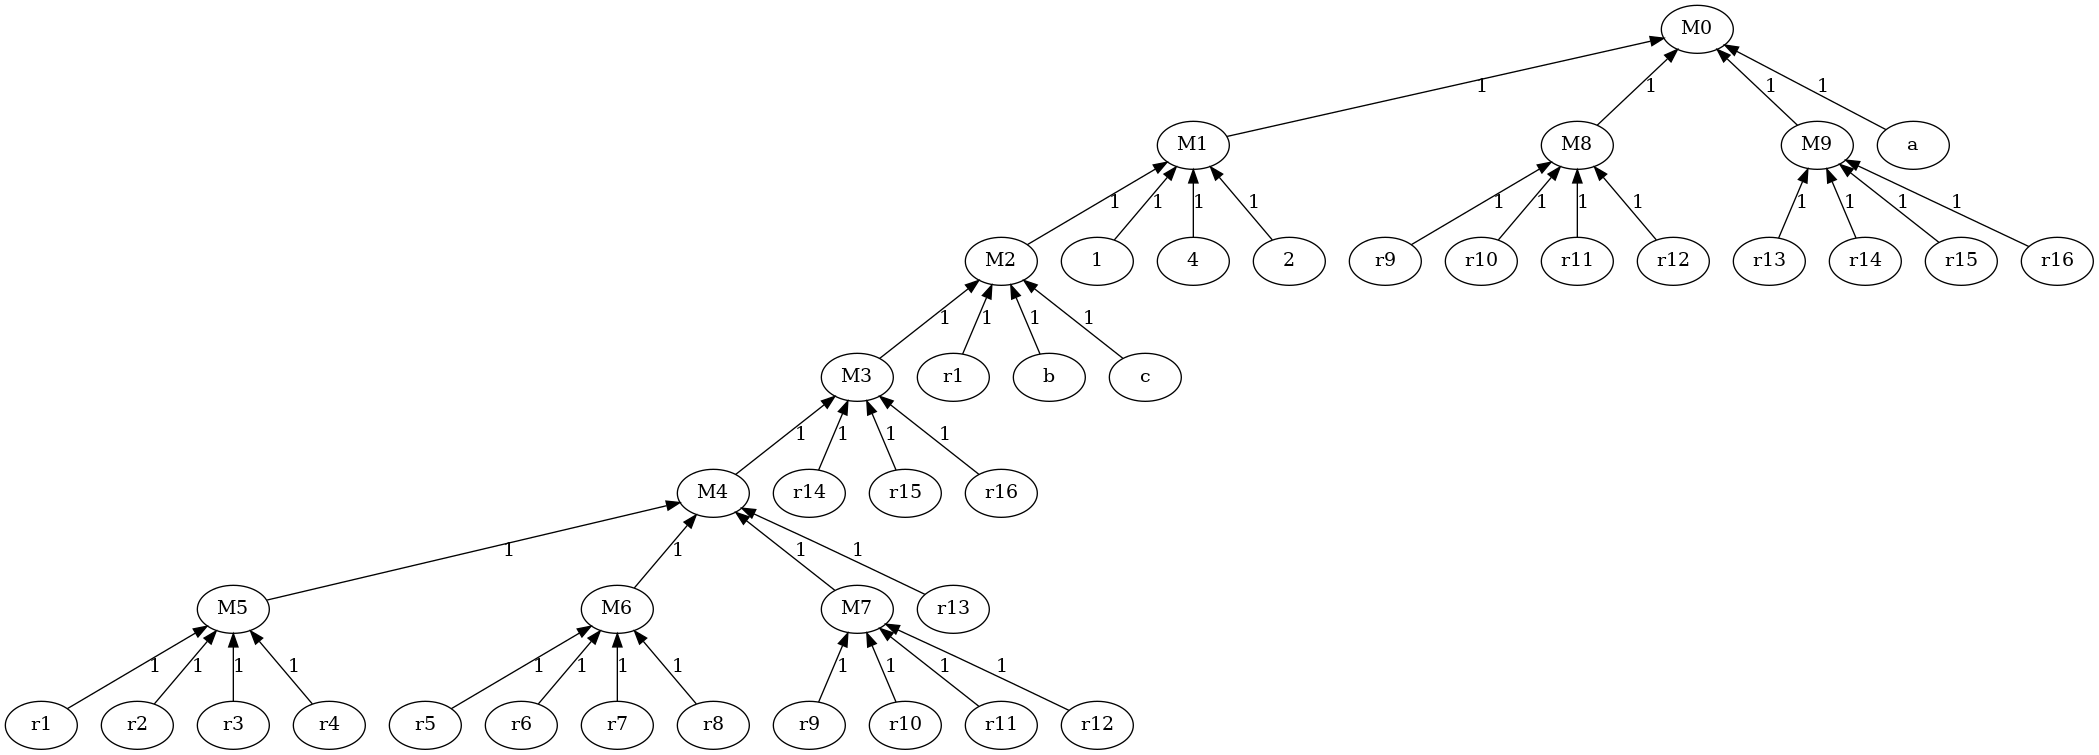

In [6]:
viewTree(t)

In [ ]:
visualize_placement(info, axis=[[0,9], [0,9]], save_dir='final_frame')

In [8]:
temp = Grid('gtm', inlet=str([0,0]), outlet=str([7,7]), height=8, width=8, buffer='b', mixer_cycles=5)
print(temp)        

Creating directory:  ././frames
snapshotting..1
Grid ID:gtm, Height:8, Width:8, Inlet:[0, 0], Outlet:[7, 7], Mixer Cycles:5


/home/sparrow/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: You passed a edgecolor/edgecolors ('gray') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7fefa446de70>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  node_collection = ax.scatter(


In [ ]:
for t in range(1, getTimeCount(info)+1):
    currTimeOps = []
    for item in info:
        if item[1] == t:
            currTimeOps.append(item)
    # load all
    for item in currTimeOps:
#         print ('loading :', item[2], str(item[2]))
        if len(item) == 3:
            temp.load(item[0], [str(item[2])])
    # mix all
    mixer_list = []
    for item in currTimeOps:
        if len(item) == 4:
            mixer_list.append([item[0], [str(j) for j in item[2]]])
    temp.mix(mixer_list)
    # wash all
    for item in currTimeOps:
        if len(item) == 4:
            for j in item[3]:
                temp.wash([str(j)])
#             temp.wash([str(j for j in item[3])])

### Rough

In [69]:

temp = Grid('gtm', inlet=str([0,0]), outlet=str([7,7]), height=8, width=8, buffer='b')
temp.load('r1', [str([4,4])])

# temp.load('r2', [str([0,2])])

# temp.mix([
#     [ 'm21', [str([1,2]), str([1,3]), str([2,3]), str([2,2])] ],
#     [ 'm3',[str([3,0]), str([3,1]), str([4,1]), str([4,0])] ]
#     ])

temp.wash([str([4,4])])

snapshotting..1
snapshotting..2
snapshotting..3
snapshotting..4
snapshotting..5
snapshotting..6
snapshotting..7
snapshotting..8
snapshotting..9
snapshotting..10
snapshotting..11
snapshotting..12
snapshotting..13
snapshotting..14
snapshotting..15
snapshotting..16
snapshotting..17
snapshotting..18
snapshotting..19
snapshotting..20
snapshotting..21
snapshotting..22
snapshotting..23
snapshotting..24
snapshotting..25
snapshotting..26
snapshotting..27
snapshotting..28
snapshotting..29
snapshotting..30
snapshotting..31
snapshotting..32
snapshotting..33
snapshotting..34
snapshotting..35
snapshotting..36
snapshotting..37
snapshotting..38
snapshotting..39
snapshotting..40
snapshotting..41
snapshotting..42
snapshotting..43
snapshotting..44
snapshotting..45
snapshotting..46
snapshotting..47
snapshotting..48
snapshotting..49
snapshotting..50
snapshotting..51
